In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks
from scipy.stats import cauchy, binom, norm
from scipy.optimize import curve_fit
import allantools
import sys
sys.path.append('./')
from simul_utils import lineshape, k_p, allan_deviation, sampling_cycle, FWHM, sampled_lineshape
import pandas as pd
import os

### Zeeman pair lineshapes

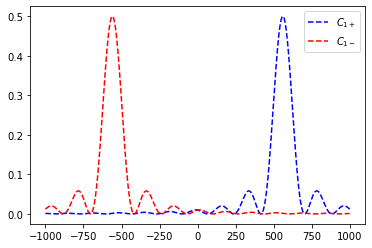

In [2]:
zeeman_coeff = 5.6 # Hz/nT
linear_zeeman = lambda B: zeeman_coeff*B
deltas = np.linspace(-1000, 1000, 1000)
center = 0.
B = 100
tau_pi = 6e-3
peak_p = lineshape(deltas, 6e-3, False, center=center+linear_zeeman(B))
peak_m = lineshape(deltas, 6e-3, False, center=center-linear_zeeman(B))
peaks = peak_p + peak_m
plt.plot(deltas, peak_p, linestyle='--', color='b', label=r"$C_{1+}$")
plt.plot(deltas, peak_m, linestyle='--', color='r', label=r"$C_{1-}$")
plt.legend()

### Zeeman peak separation discriminant function

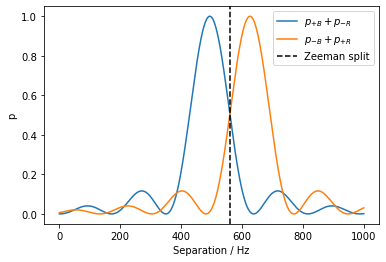

In [28]:
seps = np.linspace(0, 1000, 1000)
z_s = linear_zeeman(B)
HWHM = FWHM(lineshape(deltas, tau_pi, center=linear_zeeman(B)), deltas)/2.
pfb_pB = lineshape(HWHM+seps, tau_pi, center=z_s)
pfb_mB = lineshape(HWHM-seps, tau_pi, center=-z_s)
pfb_pR = lineshape(-HWHM+seps, tau_pi, center=z_s)
pfb_mR = lineshape(-HWHM-seps, tau_pi, center=-z_s)
p_sep1 = pfb_pB + pfb_mR
p_sep2 = pfb_mB + pfb_pR
plt.plot(seps, p_sep1, label=r'$p_{+B}+p_{-R}$')
plt.plot(seps, p_sep2, label=r'$p_{-B}+p_{+R}$')
plt.axvline(z_s, label='Zeeman split', color='k', linestyle='--')
plt.xlabel('Separation / Hz')
plt.ylabel('p')
plt.legend()

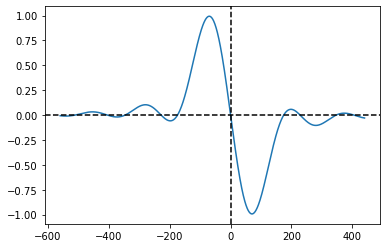

In [29]:
plt.plot(seps-z_s, p_sep1-p_sep2) 
plt.axvline(0., color='k', linestyle='--')
plt.axhline(0., color='k', linestyle='--')

### Line center lineshapes and discriminant

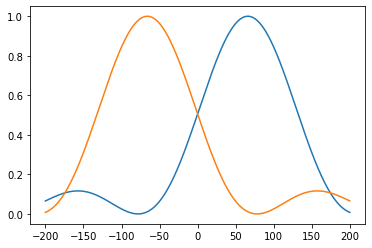

In [16]:
delta = np.linspace(-200, 200, 1000)
z_s = linear_zeeman(B)
pfb_pB = lineshape(z_s + HWHM + delta, tau_pi, center=z_s)
pfb_mB = lineshape(-z_s + HWHM + delta, tau_pi, center=-z_s)
pfb_pR = lineshape(z_s - HWHM + delta, tau_pi, center=z_s)
pfb_mR = lineshape(-z_s - HWHM + delta, tau_pi, center=-z_s)
pfb_1 = pfb_mR+pfb_pR
pfb_2 = pfb_mB+pfb_pB
plt.plot(delta,pfb_1)
plt.plot(delta,pfb_2)

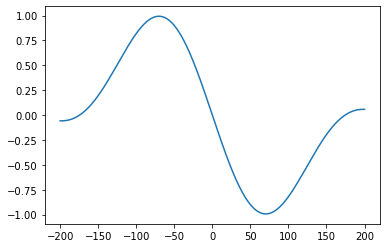

In [17]:
plt.plot(delta,pfb_2 - pfb_1)

## Bichromatic simulation
### Set-up

B servo gain: 49.69 Hz, LC servo gain: 49.61 Hz


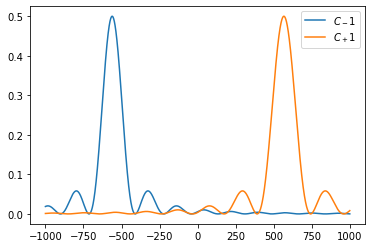

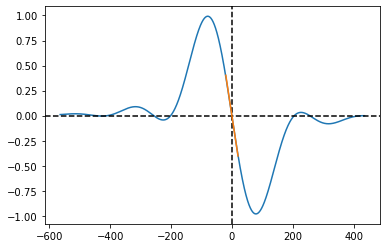

In [41]:
center = 0. # Hz, relative transition frequency
B = 100 # nT, magnetic field strength
B_drift = 0.01 # nT/s, B-field drift
zeeman_coeff = 5.6 # Hz/nT, Zeeman peak coefficient
linear_zeeman = lambda B: zeeman_coeff*B
z_s = linear_zeeman(B) # initial linear Zeeman shift
tau_pi = 6e-3 # Pi-pulse length
n_s = 100 # number of samples
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c # s, total sampling time
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=0, stop=max_tau+n_c*T_s, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_B = np.zeros(len(t)) # Zeeman peak separation servo
eta_C = np.zeros(len(t)) # Line center serco
B_field = np.zeros(len(t))
B_field[0] = B
d, step = np.linspace(-1000, 1000, 100000, retstep=True)
d_sample = np.linspace(-1000, 1000, 10)

# initialize centers, k_ps and gains
f_cavity = 0. # laser initially in the center
f_centers = np.zeros(n_c)
servo_gains = np.zeros(2)
fwhms = np.zeros(n_c)
coeffs = [-1,1]
taus = np.zeros(n_c)
for center in range(len(coeffs)):
    # sample ideal lineshape
    l_sample = sampled_lineshape(lineshape, 
                                 d_sample,
                                 tau_pi=tau_pi,
                                 state_prep=state_preparation,
                                 samples_per_point=100,
                                 linecenter=coeffs[center]*z_s)
    # fit to sampled to simulate real measurement
    popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample,
                           l_sample, p0=[6e-3, coeffs[center]*z_s])
    fit_shape = lineshape(d, popt[0], state_preparation, popt[1])
    plt.plot(d,fit_shape,label=rf'$C_{coeffs[center]:+}$')
    # calculate FWHM
    width = peak_widths(fit_shape, [np.argmax(fit_shape)], rel_height=0.5)
    fwhms[center] = d[int(width[3][0])] - d[int(width[2][0])]
    # save results to vector
    f_centers[center] = popt[1]
    taus[center] = popt[0]
plt.legend()
# set up B servo
eta_B[0] = np.mean(np.abs(f_centers))
seps, sep_step = np.linspace(0, 1000, 10000, retstep=True)
pB_pB = lineshape(fwhms[1]/2.+seps, taus[1], center=f_centers[1])
pB_mB = lineshape(fwhms[0]/2.-seps, taus[0], center=f_centers[0])
pB_pR = lineshape(-fwhms[1]/2.+seps, taus[1], center=f_centers[1])
pB_mR = lineshape(-fwhms[0]/2.-seps, taus[0], center=f_centers[0])
p_sep1 = pB_pB + pB_mR
p_sep2 = pB_mB + pB_pR
k_B = p_sep1 - p_sep2
dk_B = np.diff(k_B) / sep_step
k_pB = dk_B[np.argmin(np.abs(seps-eta_B[0]))]
servo_gains[0] = -2 * 0.5/k_pB
fig, ax = plt.subplots()
ax.plot(seps-eta_B[0], k_B)
ax.axvline(0., color='k', linestyle='--')
ax.axhline(0., color='k', linestyle='--')
ax.plot(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)*k_pB)
#set up LC servo
pfb_pB = lineshape(f_centers[0] + fwhms[0]/2. + d, taus[0], center=f_centers[0])
pfb_mB = lineshape(f_centers[1] + fwhms[1]/2. + d, taus[1], center=f_centers[1])
pfb_pR = lineshape(f_centers[0] - fwhms[0]/2. + d, taus[0], center=f_centers[0])
pfb_mR = lineshape(f_centers[1] - fwhms[1]/2. + d, taus[1], center=f_centers[1])
pfb_1 = pfb_mR+pfb_pR
pfb_2 = pfb_mB+pfb_pB
k_C = pfb_2-pfb_1
dk_C = np.diff(k_C) / step
k_p_lc = dk_C[np.argmin(np.abs(d))]
servo_gains[1] = (-2*0.5)/k_p_lc
eta_C[0] = np.mean(f_centers)
print(f"B servo gain: {servo_gains[0]:.2f} Hz, LC servo gain: {servo_gains[1]:.2f} Hz")
ps = np.zeros((len(t), 6)) # container for probabilites

### Run simulation

In [42]:
for i in range(1, len(t)):
    tau = t[i]
    # sample probabilities. Laser drifts only once per pair as two sites are sampled simultaneously (is this a problem?)
    p_mB, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]-eta_B[i-1]+fwhms[0]/2., linecenter=-z_s, tau_pi=tau_pi, laser_drift=0.)
    p_pR, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]+eta_B[i-1]-fwhms[1]/2., linecenter=z_s, tau_pi=tau_pi, laser_drift=laser_drift)
    p_pB, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]+eta_B[i-1]+fwhms[1]/2., linecenter=z_s, tau_pi=tau_pi, laser_drift=0.)
    p_mR, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]-eta_B[i-1]-fwhms[0]/2., linecenter=-z_s, tau_pi=tau_pi, laser_drift=laser_drift)
    
    # Control B servo
    p_sep1 = p_pB + p_mR
    p_sep2 = p_mB + p_pR
    discriminant_B = np.divide(p_sep1 - p_sep2, p_sep1 + p_sep2)
    eta_B[i] = eta_B[i-1] + discriminant_B * servo_gains[0]
    
    # Control LC servo
    pfb_1 = p_mR+p_pR
    pfb_2 = p_mB+p_pB
    ps[i,:] = [p_mR, p_mB, p_pR, p_pB, pfb_1, pfb_2]
    discriminant_LC = (pfb_2 - pfb_1) / (pfb_2 + pfb_1)
    eta_C[i] = eta_C[i-1] + discriminant_LC * servo_gains[1]

    eta_cavity[i] = f_cavity

    # Drift mg-field
    B_field[i] = B_field[i-1] + B_drift
    z_s = linear_zeeman(B_field[i])

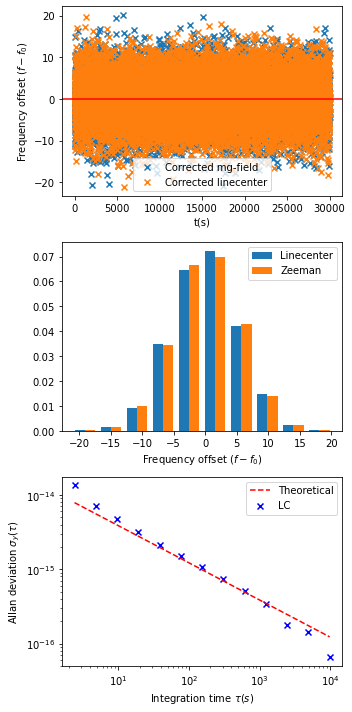

In [51]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
eta_corrected = eta_C + eta_cavity
ax[0].scatter(t, eta_B - linear_zeeman(B_field), label='Corrected mg-field', marker='x')
ax[0].scatter(t, eta_corrected, label='Corrected linecenter', marker='x')
ax[0].axhline(np.mean(eta_B - linear_zeeman(B_field)), color='r')
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[0].legend()
ax[1].hist([eta_corrected,eta_B - linear_zeeman(B_field)], density=True, label=['Linecenter', 'Zeeman'])
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
ax[1].legend()
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.5, k_p_lc, f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="LC")
ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

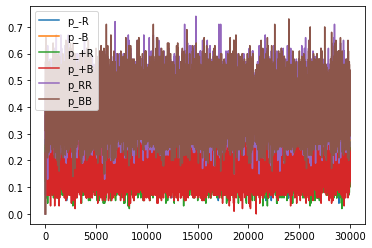

In [44]:
plt.plot(t, ps[:, 0], label='p_-R')
plt.plot(t, ps[:, 1], label='p_-B')
plt.plot(t, ps[:, 2], label='p_+R')
plt.plot(t, ps[:, 3], label='p_+B')
plt.plot(t, ps[:, 4], label='p_RR')
plt.plot(t, ps[:, 5], label='p_BB')
plt.legend()
#plt.xlim([0, 4000])

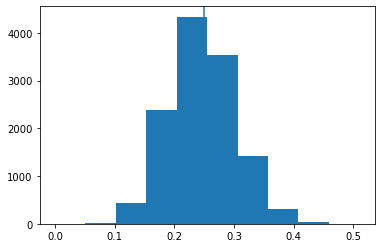

In [56]:
plt.hist(ps[:, 1])
plt.axvline(.25)

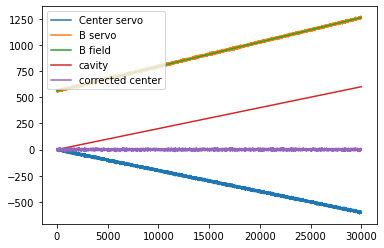

In [45]:
plt.plot(t, eta_C, label='Center servo')
plt.plot(t, eta_B, label='B servo')
plt.plot(t, linear_zeeman(B_field), label='B field')
plt.plot(t, eta_cavity, label='cavity')
plt.plot(t, eta_cavity+eta_C, label='corrected center')
plt.legend()